Processing file set 1:
Keys in Preprocessed File: dict_keys(['__header__', '__version__', '__globals__', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80'])
Keys in Features File: dict_keys(['__header__', '__version__', '__globals__', 'psd_1', 'de_1', 'de_LDS_1', 'psd_2', 'de_2', 'de_LDS_2', 'psd_3', 'de_3', 'de_LDS_3', 'psd_4', 'de_4', 'de_LDS_4', 'psd_5', 'de_5', 'de_LDS_5', 'psd_6', 'de_6', 'de_LDS_6', 'psd_7', 'de_7', 'de_LDS_7', 'psd_8', 'de_8', 'de_LDS_8', 'psd_9', 'de_9', 'de_LDS_9', 'psd_10', 'de_10', 'de_LDS_10', 'psd_11', 'de_11', 'de_LDS_11', 'psd_12', 'de_12', '

C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Resampled data shape: (2440, 32, 32), Labels shape: (2440,)
Class distribution: {np.int64(0): np.int64(488), np.int64(1): np.int64(488), np.int64(2): np.int64(488), np.int64(3): np.int64(488), np.int64(4): np.int64(488)}

Training CNN Model...
Epoch 1, Train Loss: 1.6329, Val Loss: 1.5839
Epoch 2, Train Loss: 1.5848, Val Loss: 1.5606
Epoch 3, Train Loss: 1.5720, Val Loss: 1.5437
Epoch 4, Train Loss: 1.5498, Val Loss: 1.5314
Epoch 5, Train Loss: 1.5106, Val Loss: 1.5043
Epoch 6, Train Loss: 1.4871, Val Loss: 1.4826
Epoch 7, Train Loss: 1.4575, Val Loss: 1.4745
Epoch 8, Train Loss: 1.4313, Val Loss: 1.4531
Epoch 9, Train Loss: 1.3930, Val Loss: 1.4530
Epoch 10, Train Loss: 1.3624, Val Loss: 1.4384
Epoch 11, Train Loss: 1.3457, Val Loss: 1.4213
Epoch 12, Train Loss: 1.3251, Val Loss: 1.4214
Epoch 13, Train Loss: 1.3145, Val Loss: 1.4100
Epoch 14, Train Loss: 1.3027, Val Loss: 1.4105
Epoch 15, Train Loss: 1.2988, Val Loss: 1.4081
Epoch 16, Train Loss: 1.3508, Val Loss: 1.4322
Epoch 17, Tra

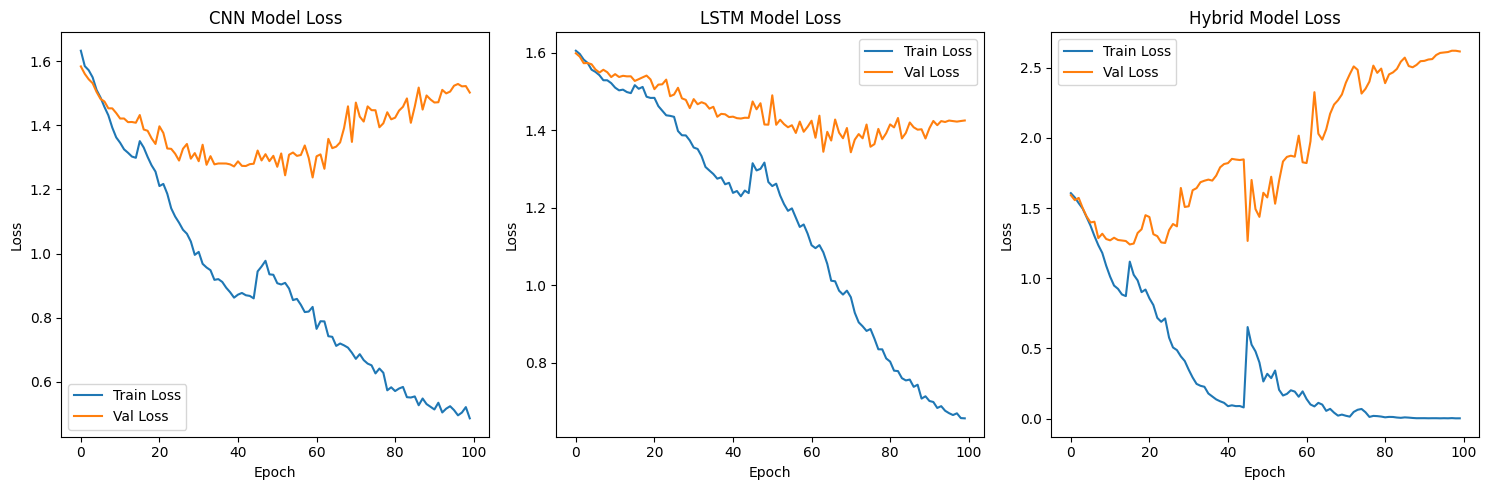

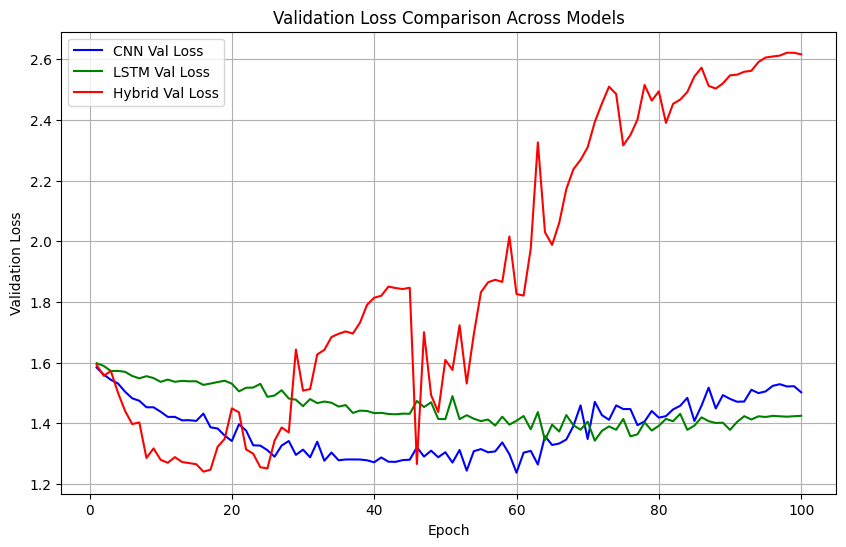

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# === Data Loading and Preprocessing ===
def load_and_preprocess_data(base_path='D:/DL_Project/', file_ids=range(1, 20)):
    all_eeg_data, all_labels = [], []
    for fid in file_ids:
        file_num = str(fid)
        preprocessed_file = f'{base_path}eeg_preprocessed/{file_num}.mat'
        features_file = f'{base_path}eeg_features/{file_num}.mat'
        labels_file = f'{base_path}continuous_labels/{file_num}.mat'

        # Load .mat files
        preprocessed_data = scipy.io.loadmat(preprocessed_file)
        features_data = scipy.io.loadmat(features_file)
        labels_data = scipy.io.loadmat(labels_file)

        print(f"Processing file set {file_num}:")
        print("Keys in Preprocessed File:", preprocessed_data.keys())
        print("Keys in Features File:", features_data.keys())
        print("Keys in Labels File:", labels_data.keys())

        # Load EEG features (differential entropy 'de_1' to 'de_80')
        eeg_features = []
        fixed_time_segments = 15  # Adjust based on your data
        for key in range(1, 81):
            key_str = f'de_{key}'
            if key_str in features_data:
                trial_data = features_data[key_str]
                print(f"Shape of trial {key} ('{key_str}'): {trial_data.shape}")

                # Ensure shape is (time_segments, bands, channels=62)
                if trial_data.shape[2] == 62:
                    pass
                elif trial_data.shape[0] == 62:
                    trial_data = trial_data.transpose(2, 1, 0)
                elif trial_data.shape[1] == 62:
                    trial_data = trial_data.transpose(2, 0, 1)
                else:
                    raise ValueError(f"Unexpected shape for trial {key}: {trial_data.shape}")

                # Pad or crop to fixed_time_segments
                current_time_segments = trial_data.shape[0]
                if current_time_segments > fixed_time_segments:
                    trial_data = trial_data[:fixed_time_segments, :, :]
                elif current_time_segments < fixed_time_segments:
                    pad_width = fixed_time_segments - current_time_segments
                    trial_data = np.pad(trial_data, ((0, pad_width), (0, 0), (0, 0)), mode='constant')
                
                eeg_features.append(trial_data)

        if not eeg_features:
            raise ValueError(f"No EEG features found in {features_file}")
        eeg_features = np.array(eeg_features)
        print(f"EEG features shape for file {file_num}: {eeg_features.shape}")

        # Load and process labels
        labels = []
        for key in range(1, 81):
            key_str = str(key)
            if key_str in labels_data:
                label = labels_data[key_str]
                current_time_segments = label.shape[1] if label.ndim > 1 else 1
                if current_time_segments > fixed_time_segments:
                    label = label[:, :fixed_time_segments]
                elif current_time_segments < fixed_time_segments:
                    pad_width = fixed_time_segments - current_time_segments
                    label = np.pad(label, ((0, 0), (0, pad_width)), mode='constant')
                labels.append(label)

        if not labels:
            raise ValueError(f"No labels found in {labels_file}")
        labels = np.array(labels)
        print(f"Raw labels shape for file {file_num}: {labels.shape}")

        # Average labels over time segments
        if labels.ndim == 3:
            labels = np.mean(labels, axis=2)
        elif labels.ndim == 2:
            labels = np.mean(labels, axis=1, keepdims=True)
        labels = labels.squeeze()

        # Map continuous labels to discrete emotions
        discrete_labels = np.zeros(labels.shape[0], dtype=int)
        for i, label in enumerate(labels):
            label = label / 100.0 if label > 10 else label / 10.0  # Normalize
            if label <= 0.2:
                discrete_labels[i] = 0  # Neutral
            elif 0.2 < label <= 0.4:
                discrete_labels[i] = 1  # Sad
            elif 0.4 < label <= 0.6:
                discrete_labels[i] = 2  # Happy
            elif 0.6 < label <= 0.8:
                discrete_labels[i] = 3  # Fear
            else:
                discrete_labels[i] = 4  # Angry
        labels = discrete_labels
        print(f"Processed labels shape for file {file_num}: {labels.shape}, Unique labels: {np.unique(labels)}")

        all_eeg_data.append(eeg_features)
        all_labels.append(labels)

    # Concatenate across files
    all_eeg_data = np.concatenate(all_eeg_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print(f"Total EEG data shape: {all_eeg_data.shape}, Total labels shape: {all_labels.shape}")

    # Reshape for CNN (32x32)
    n_trials = all_eeg_data.shape[0]
    eeg_data = []
    for trial in range(n_trials):
        trial_data = all_eeg_data[trial]
        trial_data = np.mean(trial_data, axis=2)  # Average over bands
        if trial_data.shape[1] > 32:
            trial_data = trial_data[:, :32]
        elif trial_data.shape[1] < 32:
            trial_data = np.pad(trial_data, ((0, 0), (0, 32 - trial_data.shape[1])), mode='constant')
        if trial_data.shape[0] > 32:
            trial_data = trial_data[:32, :]
        elif trial_data.shape[0] < 32:
            trial_data = np.pad(trial_data, ((0, 32 - trial_data.shape[0]), (0, 0)), mode='constant')
        eeg_data.append(trial_data)

    eeg_data = np.array(eeg_data)
    print(f"Reshaped EEG data shape: {eeg_data.shape}")

    # Normalize
    scaler = StandardScaler()
    eeg_data_flat = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data = scaler.fit_transform(eeg_data_flat).reshape(eeg_data.shape[0], 32, 32)

    # Balance classes with SMOTE
    smote = SMOTE(random_state=42)
    eeg_data_flat = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data_resampled, labels_resampled = smote.fit_resample(eeg_data_flat, all_labels)
    eeg_data = eeg_data_resampled.reshape(-1, 32, 32)
    print(f"Resampled data shape: {eeg_data.shape}, Labels shape: {labels_resampled.shape}")
    print(f"Class distribution: {dict(zip(*np.unique(labels_resampled, return_counts=True)))}")

    return eeg_data, labels_resampled

# === CNN Model ===
class CNNModel(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size=32, hidden_size=64, num_layers=2, num_classes=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.4, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Input size is hidden_size * 2 for bidirectional
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        lstm_out, (hn, _) = self.lstm(x)
        # Concatenate forward and backward hidden states from the last layer
        hn_concat = torch.cat((hn[-2], hn[-1]), dim=1)  # Shape: (batch_size, hidden_size * 2) = (32, 128)
        out = self.dropout(hn_concat)
        out = self.fc(out)  # Shape: (32, 5)
        return out

# === Attention Mechanism ===
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / (self.hidden_size ** 0.5)
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        batch_size, seq_len, _ = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.matmul(self.v)
        attn_weights = torch.softmax(energy, dim=1).unsqueeze(2)
        context = (attn_weights * encoder_outputs).sum(dim=1)
        return context

# === Hybrid Model ===
class HybridModel(nn.Module):
    def __init__(self, num_classes=5):
        super(HybridModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.hidden_size = 128
        self.lstm = nn.LSTM(32 * 8, self.hidden_size, num_layers=2, batch_first=True, bidirectional=True, dropout=0.4)
        self.attention = Attention(self.hidden_size * 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.hidden_size * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 8, 32 * 8)
        lstm_out, (hn, _) = self.lstm(x)
        hn = torch.cat((hn[-2], hn[-1]), dim=1)
        context = self.attention(hn, lstm_out)
        out = self.dropout(self.relu(context))
        out = self.fc(out)
        return out

# === Training and Evaluation ===
def train_and_evaluate(model, train_loader, test_loader, num_epochs=100, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=2, eta_min=1e-6)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        val_loss = val_loss / len(test_loader)
        val_losses.append(val_loss)

        scheduler.step(epoch + 1)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return train_losses, val_losses, accuracy, precision, recall, f1, cm

# === Main Execution ===
eeg_data, labels = load_and_preprocess_data()
X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.2, random_state=42)

# Prepare data for CNN
X_train_cnn = torch.FloatTensor(X_train).unsqueeze(1)  # Add channel dimension
X_test_cnn = torch.FloatTensor(X_test).unsqueeze(1)
y_train_t = torch.LongTensor(y_train)
y_test_t = torch.LongTensor(y_test)

# Prepare data for LSTM
X_train_lstm = torch.FloatTensor(X_train)
X_test_lstm = torch.FloatTensor(X_test)

# DataLoaders
train_dataset_cnn = TensorDataset(X_train_cnn, y_train_t)
test_dataset_cnn = TensorDataset(X_test_cnn, y_test_t)
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=32)

train_dataset_lstm = TensorDataset(X_train_lstm, y_train_t)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True)
test_loader_lstm = DataLoader(TensorDataset(X_test_lstm, y_test_t), batch_size=32)

# Models
models = {
    'CNN': CNNModel(),
    'LSTM': LSTMModel(),
    'Hybrid': HybridModel()
}

# Training and evaluation
results = {}
for name, model in models.items():
    print(f"\nTraining {name} Model...")
    train_loader = train_loader_cnn if name != 'LSTM' else train_loader_lstm
    test_loader = test_loader_cnn if name != 'LSTM' else test_loader_lstm
    train_losses, val_losses, acc, prec, rec, f1, cm = train_and_evaluate(model, train_loader, test_loader)
    results[name] = {'train_losses': train_losses, 'val_losses': val_losses, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'confusion_matrix': cm}
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# === Visualization ===
plt.figure(figsize=(15, 5))
for i, name in enumerate(results, 1):
    plt.subplot(1, 3, i)
    plt.plot(results[name]['train_losses'], label='Train Loss')
    plt.plot(results[name]['val_losses'], label='Val Loss')
    plt.title(f'{name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()

# New comparison plot for validation losses
plt.figure(figsize=(10, 6))
num_epochs = len(results['CNN']['val_losses'])
epochs = range(1, num_epochs + 1)

plt.plot(epochs, results['CNN']['val_losses'], label='CNN Val Loss', color='blue')
plt.plot(epochs, results['LSTM']['val_losses'], label='LSTM Val Loss', color='green')
plt.plot(epochs, results['Hybrid']['val_losses'], label='Hybrid Val Loss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison Across Models')
plt.legend()
plt.grid(True)
plt.show()